*Maestría de Ciencia de Datos - UNAJ*

# Trabajo Final: Aplicaciones de Ciencia de datos

*Febrero 2026*

## Integrantes
- Raul Burgos
- Mauro Cejas Marcovecchio
- Raul Muñoz
- Mirta Soto

## Descripción

El objetivo del siguiente trabajo es el análisis exploratorio, preprocesamiento de datos y el desarrollo de modelos de machine
learning sobre el dataset provisto por el Sistema de Información y Gestión Agrometeorológica (SIGA), del [Instituto Nacional de Tecnología Agropecuaria (INTA)](https://siga.inta.gob.ar/). Esta base de datos contiene información agrometeorológica de la Provincia de Corrientes, Argentina.


In [ ]:
# Apuntes 10/12:

# Tenemos que unificar los tres archivos
# Los datasets tienen fecha del 08-12-2025, están actualizados.
# Estos provienen de tres estaciones meteorológicas distintas, aunque cercanas.
# En la pestaña 'Datos estacion' nos da más información sobre cada estación.
# Los valores están tomados con medidas diarias, no corresponden a un momento específico del día.

# Variable objetivo: El valor que más nos va a interesar es la radiación global (columna AB)
# De las 500 estaciones meteorológicas del INTA, solo 40 tienen información sobre radiación global.
# ¿Podríamos predecir la radiación con menos cantidad de información que la que tenemos?
# Falta de sentido de agregar muchas variables. 
# Nos van a pedir que nos quedemos con las 4, 5, 6 variables que más servirían para modelar la radiación solar..

# Fecha: es fundamental por la época del año, aunque también se refleja en el resto de los parámetros.
# Podríamos hacer un análisis completo, o un análisis estacional 
# (filtrando los datos por estación codificando los valores de las fechas, por ejemplo).

# Vacíos en la variable Radiación_Global: vamos a tener que considerar solo aquellas filas que tengan valor en dicha columna para poder
# hacer el entrenamiento y el testeo. 

# Ver si rinde sumar el dato de latitud y longitud sobre los que se ubiquen las estaciones meteorológicas.

# No va  a haber algo que esté mal o que esté bien, sino que lo importante va a ser la explicación que demos de las decisiones que tomemos.
# El objetivo no es que las métricas sean perfectas, sino que empecemos a entender la aplicación de la ciencia de datos
# e ir aplicando las distintas herramientas que fuimos aprendiendo a lo largo de la maeestría
# El objetivo no es obtener las métricas óptimas, sino el desarrollo del trabajo.
# Preparación para la tesis.

In [2]:
# Apuntes 17/12:

# Últimas 4 clases del curso van a ser después del carnaval. 
# Las primeras dos clases van a ser de consulta y las otras dos de presentación
# Si ya tenemos cerrado el trabajo, se puede presentarlo durante la primera semana para sacarnoslo de encima.

# Con que un solo integrante lo suba al espacio de entrega, estamos bien. 

# Presentaciones de 10/15 min de largo. Resumidas. En Power Point.
# Fecha de entrega máxima: 22 de febrero, para que los profesores puedan leer el informe.
# Comprimido en winrar con apellidos de los integrantes.

## EDA y Preprocesamiento

In [3]:
# (Al finalizar la Parte I se debe contar con un dataset listo 
# para ser utilizado con algoritmos de aprendizaje automático).

### Preprocesamiento básico y limpieza inicial

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Primero que nada, tenemos que importar al entorno los tres archivos provistos.
# Debido a que se trata de archivos .xls, tenemos que utilizar el engine 'xlrd' al momento de importarlos.
# El problema es que la librería xlrd ya no soporta archivos xls a partir de su versión 2.0.1
# Por lo tanto, deberíamos crear un entorno virtual con una versión anterior de xlrd (1.2.0)
# De todas formas, vamos a optar por el camino más sencillo, que es guardar los archivos en formato .xlsx manualmente y luego importarlos.

dataset1 = pd.read_excel('data/A872950.xlsx')
dataset2 = pd.read_excel('data/A872951.xlsx')
dataset3 = pd.read_excel('data/A872952.xlsx')

In [3]:
print("Dimensiones:", dataset1.shape)
print("Dimensiones:", dataset2.shape)
print("Dimensiones:", dataset3.shape)

Dimensiones: (3939, 30)
Dimensiones: (3714, 30)
Dimensiones: (2220, 30)


In [4]:
print("Categorías de los datasets:")
print(dataset1.columns)
print(dataset2.columns)
print(dataset3.columns)

# De esta manera, vamos a poder ver que las tres tablas tienen las mismas columnas y tipos de datos.
# Por lo tanto, podemos proceder a unificarlas en un solo dataset.

Categorías de los datasets:
Index(['Fecha', 'Temperatura_Abrigo_150cm', 'Temperatura_Abrigo_150cm_Maxima',
       'Temperatura_Abrigo_150cm_Minima', 'Temperatura_Intemperie_5cm_Minima',
       'Temperatura_Intemperie_50cm_Minima', 'Temperatura_Suelo_5cm_Media',
       'Temperatura_Suelo_10cm_Media', 'Temperatura_Inte_5cm',
       'Temperatura_Intemperie_150cm_Minima', 'Humedad_Suelo',
       'Precipitacion_Pluviometrica', 'Precipitacion_Cronologica',
       'Precipitacion_Maxima_30minutos', 'Heliofania_Efectiva',
       'Heliofania_Relativa', 'Tesion_Vapor_Media', 'Humedad_Media',
       'Humedad_Media_8_14_20', 'Rocio_Medio', 'Duracion_Follaje_Mojado',
       'Velocidad_Viento_200cm_Media', 'Direccion_Viento_200cm',
       'Velocidad_Viento_1000cm_Media', 'Direccion_Viento_1000cm',
       'Velocidad_Viento_Maxima', 'Presion_Media', 'Radiacion_Global',
       'Horas_Frio', 'Unidades_Frio'],
      dtype='object')
Index(['Fecha', 'Temperatura_Abrigo_150cm', 'Temperatura_Abrigo_150cm_Maxi

In [5]:
# Antes de concatenarlas, vamos a incorporar la informacion de la ubicación geográfica de cada estación meteorológica.
# Esto lo hacemos agregando tres columnas nuevas: 'Latitud', 'Longitud' y 'Localidad'

dataset1['Latitud'] = -29.1784992218018
dataset1['Longitud'] = -59.0923004150391
dataset1['Localidad'] = 'Goya' 

dataset2['Latitud'] = -28.452600479126
dataset2['Longitud'] = -58.9865989685059
dataset2['Localidad'] = 'Bella Vista'

dataset3['Latitud'] = -27.6566638946533
dataset3['Longitud'] = -58.2937927246094
dataset3['Localidad'] = 'Herliszka'

In [6]:
df = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Fecha                                9873 non-null   object 
 1   Temperatura_Abrigo_150cm             9508 non-null   float64
 2   Temperatura_Abrigo_150cm_Maxima      9493 non-null   float64
 3   Temperatura_Abrigo_150cm_Minima      9487 non-null   float64
 4   Temperatura_Intemperie_5cm_Minima    0 non-null      float64
 5   Temperatura_Intemperie_50cm_Minima   1404 non-null   float64
 6   Temperatura_Suelo_5cm_Media          0 non-null      float64
 7   Temperatura_Suelo_10cm_Media         9116 non-null   float64
 8   Temperatura_Inte_5cm                 0 non-null      float64
 9   Temperatura_Intemperie_150cm_Minima  1412 non-null   float64
 10  Humedad_Suelo                        0 non-null      float64
 11  Precipitacion_Pluviometrica   

#### Cantidad de registros y variables

Tal como podemos observar mediante la descripción del dataset que aglutina a los tres archivos, disponemos de un total de 9873 registros y 33 variables. 

De todas formas, aquellas variables vinculadas a la medición de la temperatura a la intemperie y el suelo a 5 cm, como también la humedad del suelo, no tendrán valores válidos. Por lo tanto, las quitaremos del dataset utilizado, junto a las variables vinculadas a la Heliofanía, quedándonos con solo 27 variables. La mayoría de ellas serán de tipo numérico, a excepción de las vinculadas a la dirección del viento, la ubicación y la fecha, cuyo tipo deberemos corregir.

In [8]:
# Vamos a descartar todas las columnas cuyos valores sean nulos en su totalidad, ya que no aportan información alguna.
# También, vamos a descartar las columnas referidas a la Heliofania, tal como se indicó en el enunciado.

df = df.dropna(axis = 1, how = 'all')
df = df.drop(columns = ['Heliofania_Efectiva', 'Heliofania_Relativa'])


#### Tipos de variables

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Fecha                                9873 non-null   object 
 1   Temperatura_Abrigo_150cm             9508 non-null   float64
 2   Temperatura_Abrigo_150cm_Maxima      9493 non-null   float64
 3   Temperatura_Abrigo_150cm_Minima      9487 non-null   float64
 4   Temperatura_Intemperie_50cm_Minima   1404 non-null   float64
 5   Temperatura_Suelo_10cm_Media         9116 non-null   float64
 6   Temperatura_Intemperie_150cm_Minima  1412 non-null   float64
 7   Precipitacion_Pluviometrica          9149 non-null   float64
 8   Precipitacion_Cronologica            9129 non-null   float64
 9   Precipitacion_Maxima_30minutos       8324 non-null   float64
 10  Tesion_Vapor_Media                   9437 non-null   float64
 11  Humedad_Media                 

In [10]:
df.head()

,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_10cm_Media,Temperatura_Intemperie_150cm_Minima,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,...,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio,Latitud,Longitud,Localidad
0,2013-09-03 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,,NaN,NaN,NaN,NaN,NaN,-29.178499,-59.0923,Goya
1,2013-09-04 00:00:00.0,13.49305,23.5,5.4,NaN,17.35556,NaN,0.0,0.0,0.0,...,NaN,C,NaN,NaN,NaN,3.153999,0.498000,-29.178499,-59.0923,Goya
2,2013-09-05 00:00:00.0,17.53334,28.9,9.7,NaN,18.86459,NaN,0.0,0.0,0.0,...,NaN,C,NaN,NaN,NaN,0.000000,-9.129999,-29.178499,-59.0923,Goya
3,2013-09-06 00:00:00.0,22.60834,34.1,13.8,NaN,21.49792,NaN,0.0,0.0,0.0,...,NaN,C,NaN,NaN,NaN,0.000000,-16.849020,-29.178499,-59.0923,Goya
4,2013-09-07 00:00:00.0,26.51389,36.3,20.3,NaN,23.58055,NaN,0.0,0.0,0.0,...,NaN,C,NaN,NaN,NaN,0.000000,-23.904030,-29.178499,-59.0923,Goya


In [11]:
# Vamos a convertir la columna 'Fecha' en un objeto datetime de pandas, para facilitar su manipulación posterior.
df['Fecha'] = pd.to_datetime(df['Fecha'])

#### Valores faltantes, duplicados e inconsistencias

In [13]:
na_count = df.isnull().sum().sort_values(ascending=False)
print("Valores faltantes por columna:")
print(na_count)

Valores faltantes por columna:
Temperatura_Intemperie_50cm_Minima     8469
Temperatura_Intemperie_150cm_Minima    8461
Precipitacion_Maxima_30minutos         1549
Rocio_Medio                            1119
Velocidad_Viento_1000cm_Media           875
Velocidad_Viento_200cm_Media            875
Duracion_Follaje_Mojado                 832
Radiacion_Global                        832
Presion_Media                           832
Velocidad_Viento_Maxima                 824
Temperatura_Suelo_10cm_Media            757
Precipitacion_Cronologica               744
Precipitacion_Pluviometrica             724
Horas_Frio                              447
Unidades_Frio                           446
Tesion_Vapor_Media                      436
Humedad_Media_8_14_20                   398
Temperatura_Abrigo_150cm_Minima         386
Temperatura_Abrigo_150cm_Maxima         380
Humedad_Media                           371
Temperatura_Abrigo_150cm                365
Longitud                                  0
L

In [14]:
# Vamos a contar y generar un dataframe específico con los registros duplicados.

dup_count = df.duplicated().sum()
print("Filas duplicadas:", dup_count)


Filas duplicadas: 0


In [15]:
print(df['Direccion_Viento_200cm'].unique())
print(df['Direccion_Viento_1000cm'].unique())

['  ' 'C ' 'S ' 'W ' 'E ' 'SE' 'NE' 'N ' 'NW']
['  ' 'C ']


A su vez, resulta interesante notar que los valores de la categoría referida a la dirección del viento a 1000 cm son nulos o una 'C'. Ésto es diferente a lo que ocurre en el caso de esta misma medición a 200 cm, que correctamente integra los distintos puntos cardinales. Más allá de suponer que la 'C' significa viento 'calmo' y, considerando que el 97% de los valores de esa categoría toman el mismo valor, procederemos a dejarla de lado.

In [16]:
df = df.drop(columns=['Direccion_Viento_1000cm'])


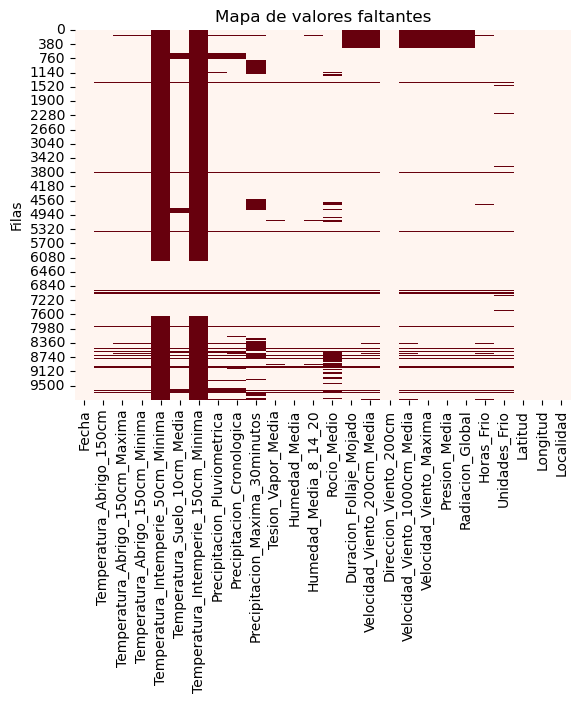

In [17]:
# Visualización simple de patrón de faltantes

sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title('Mapa de valores faltantes')
plt.ylabel('Filas')
plt.show()

In [18]:
# Viendo que temperatura Intemperie a 50 y 150 Mínima tienen aproximadamente el 85% de valores faltantes, 
# vamos a descartarlas también.

df = df.drop(columns=['Temperatura_Intemperie_50cm_Minima', 'Temperatura_Intemperie_150cm_Minima'])


#### Valores atípicos

In [ ]:
grupo1 = ['Temperatura_Abrigo_150cm', 'Temperatura_Abrigo_150cm_Maxima', 'Temperatura_Abrigo_150cm_Minima', 'Temperatura_Suelo_10cm_Media']
grupo2 = ['Precipitacion_Pluviometrica', 'Precipitacion_Cronologica', 'Precipitacion_Maxima_30minutos']
grupo3 = ['Tesion_Vapor_Media', 'Rocio_Medio']
grupo4 = ['Humedad_Media', 'Humedad_Media_8_14_20']
grupo5 = ['Duracion_Follaje_Mojado', 'Horas_Frio', 'Unidades_Frio']
grupo6 = ['Velocidad_Viento_200cm_Media', 'Velocidad_Viento_1000cm_Media', 'Velocidad_Viento_Maxima']

# Variable objetivo

plt.figure(figsize = (3, 4))
sns.boxplot(data = df[['Radiacion_Global']])
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 3))
sns.scatterplot(x = 'Fecha', y = 'Radiacion_Global', data = df)
plt.tight_layout()
plt.show()

# Presión Media

plt.figure(figsize = (3, 4))
sns.boxplot(data = df[['Presion_Media']])
plt.tight_layout()
plt.show()

plt.figure(figsize = (12, 3))
sns.scatterplot(x = 'Fecha', y = 'Presion_Media', data = df)
plt.tight_layout()
plt.show()


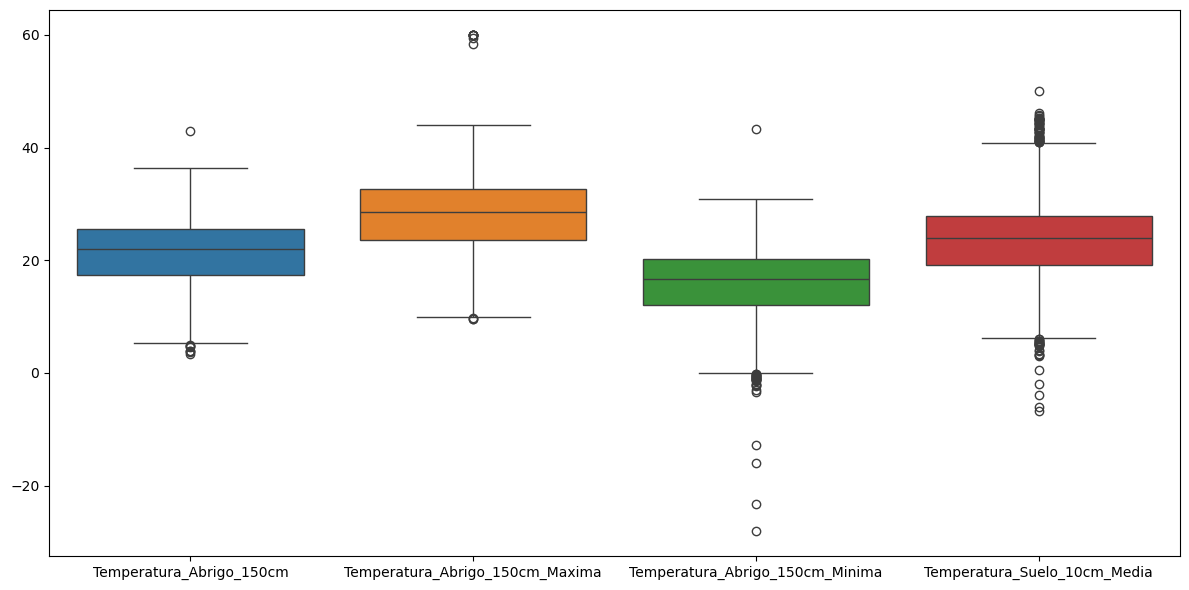

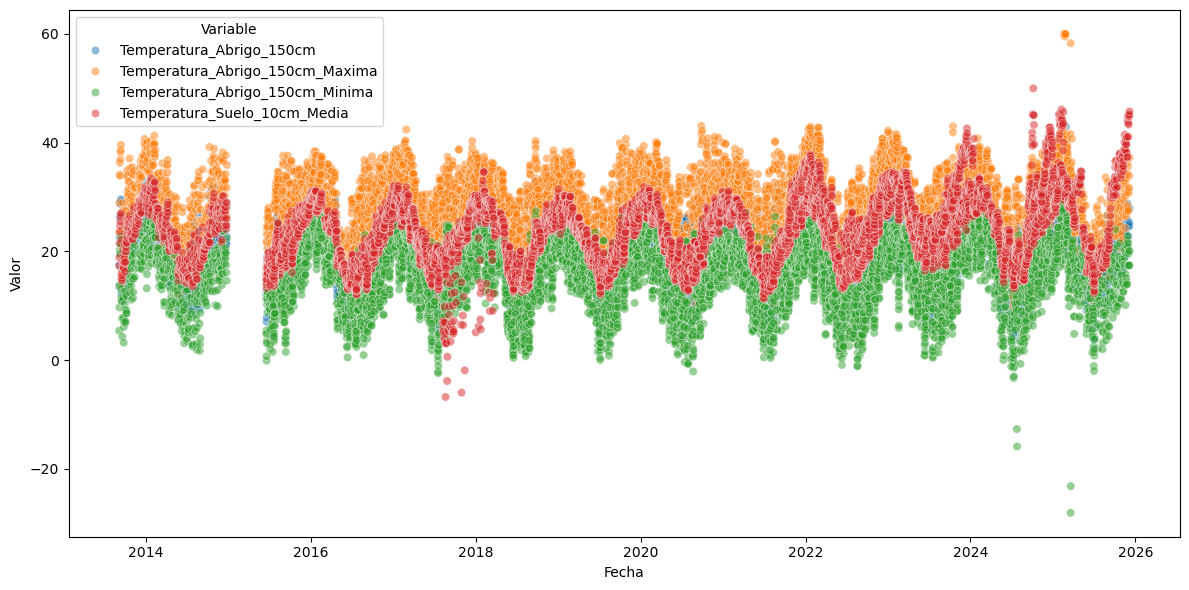

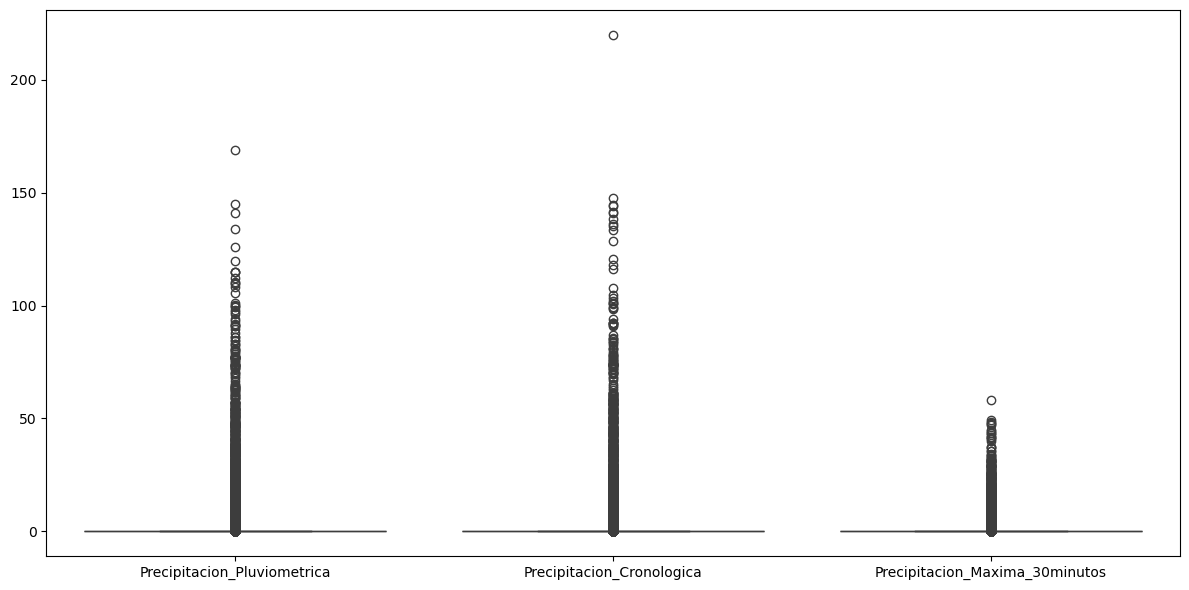

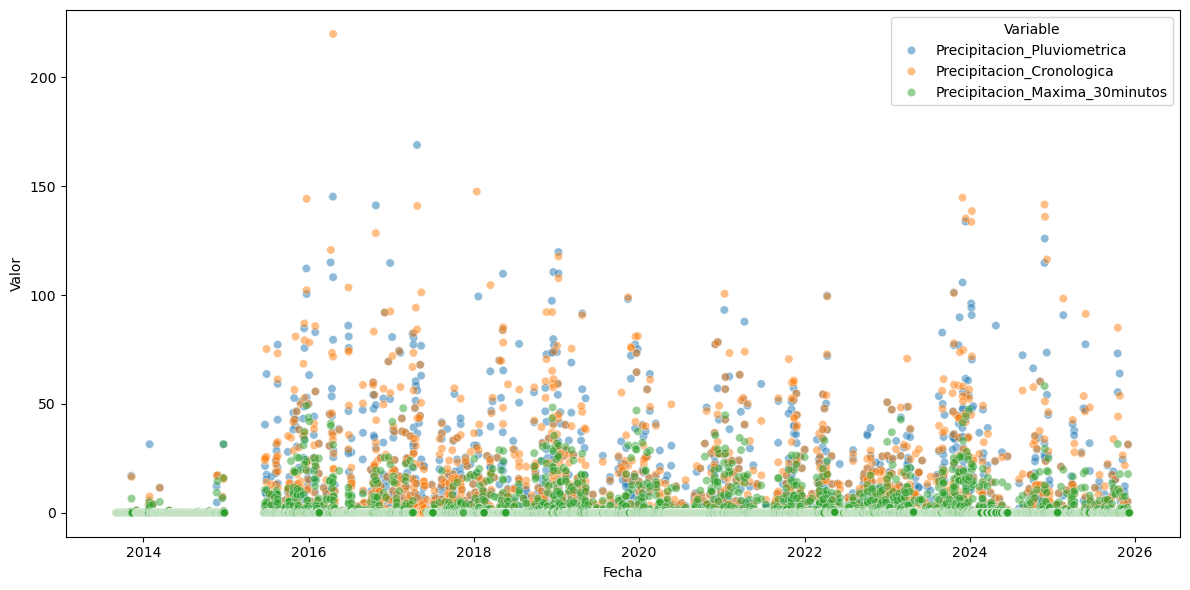

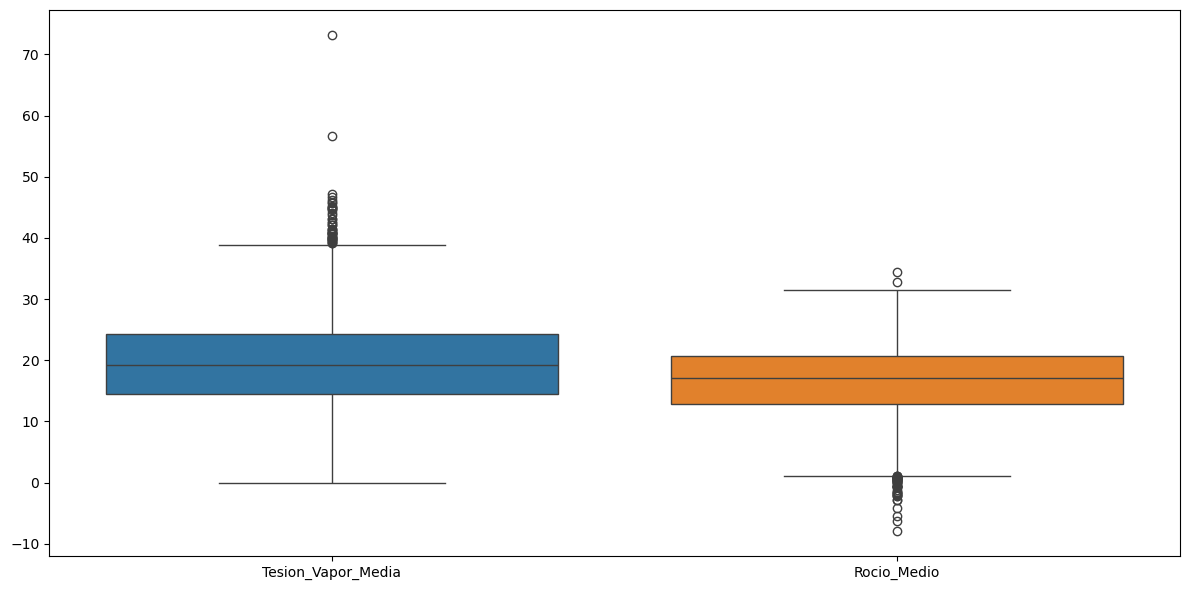

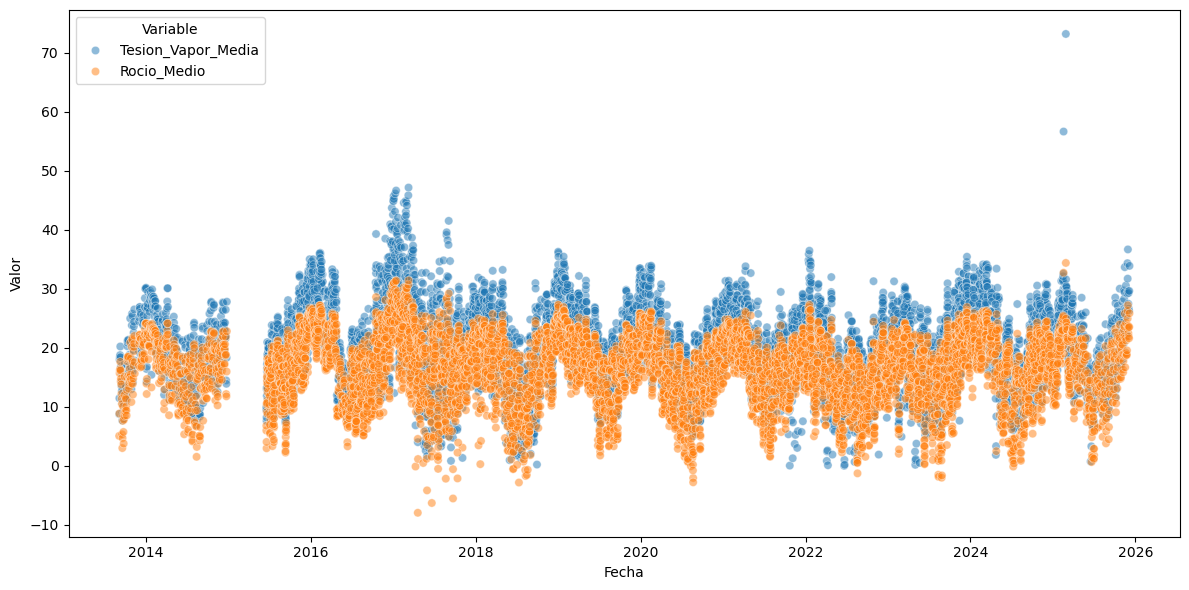

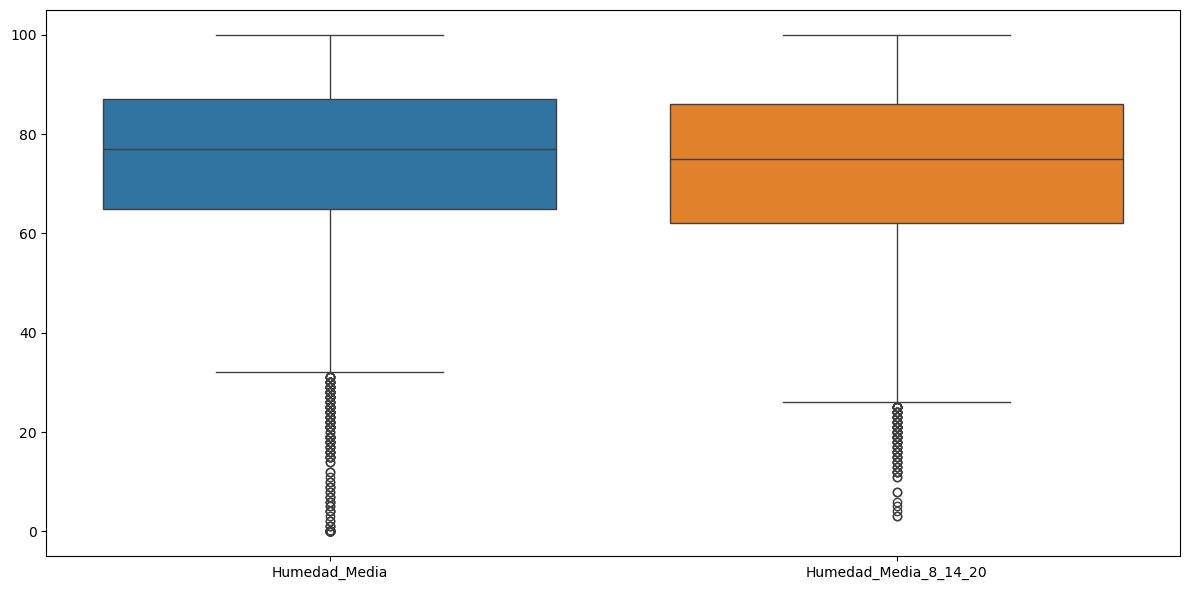

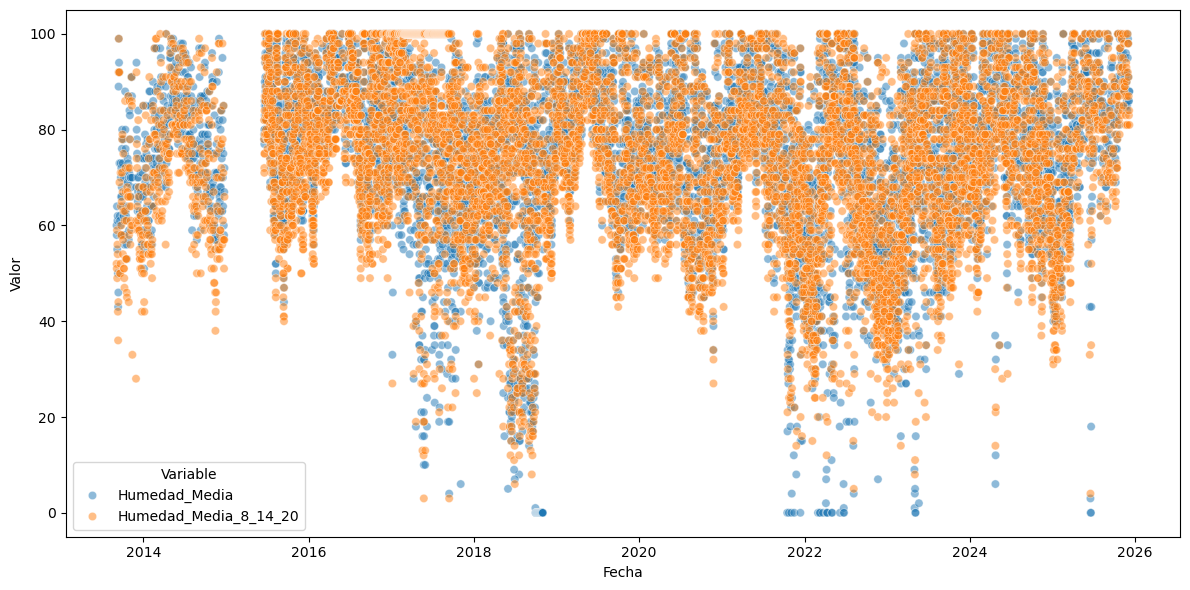

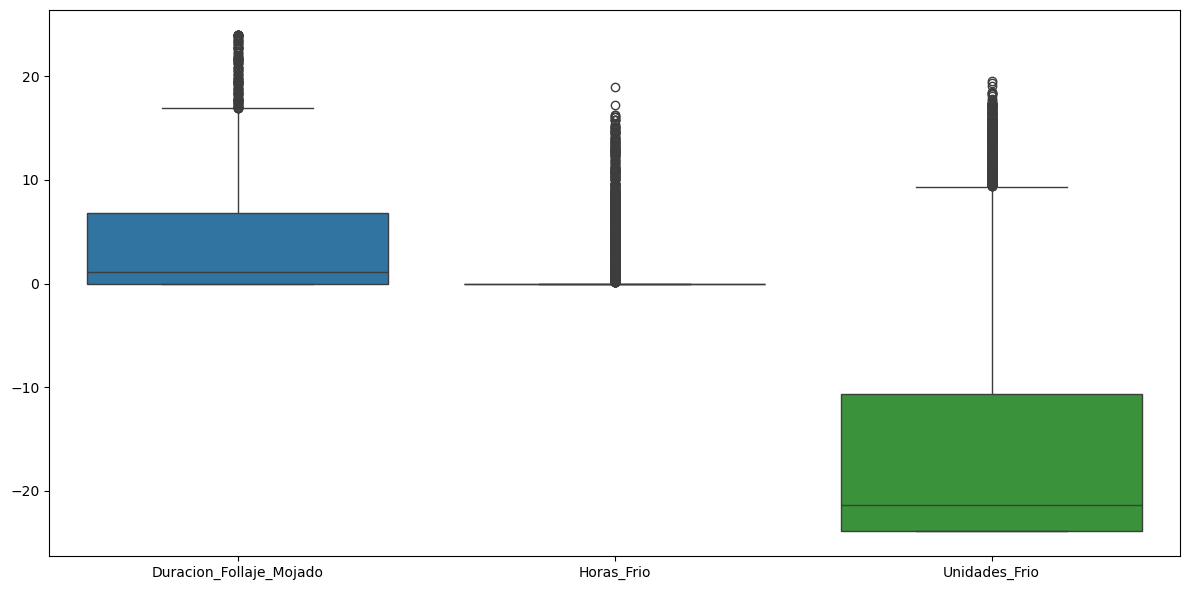

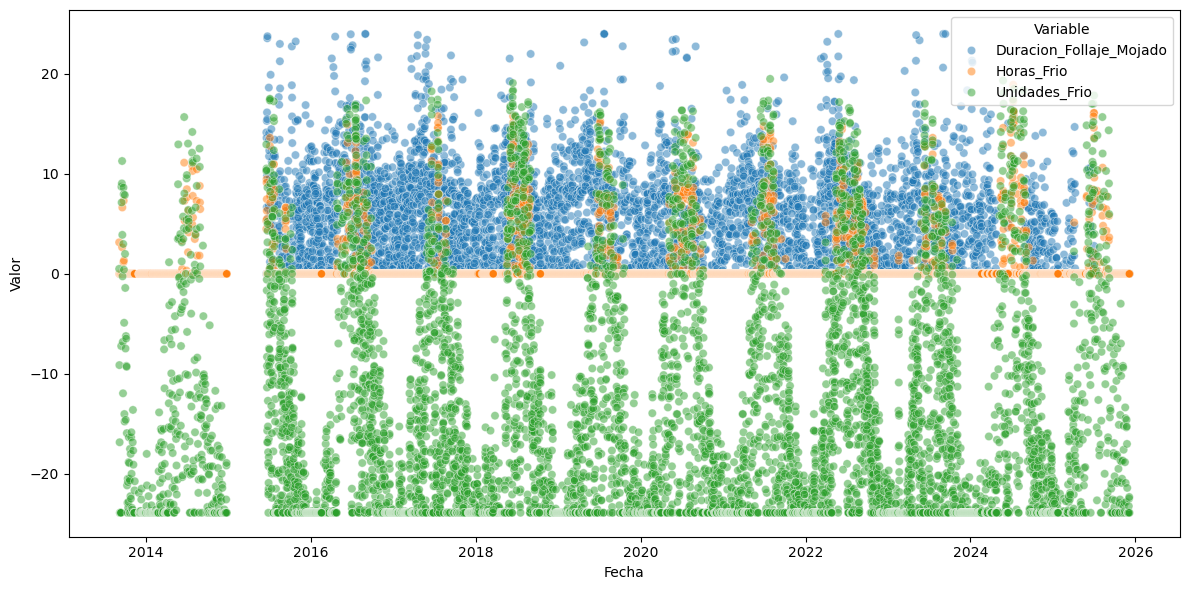

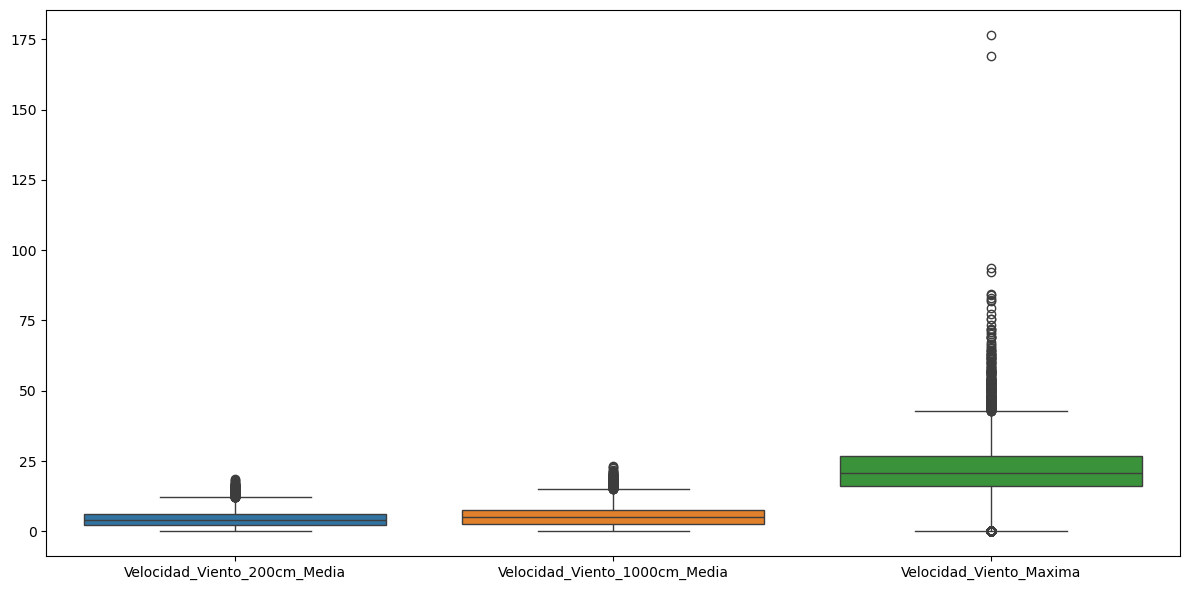

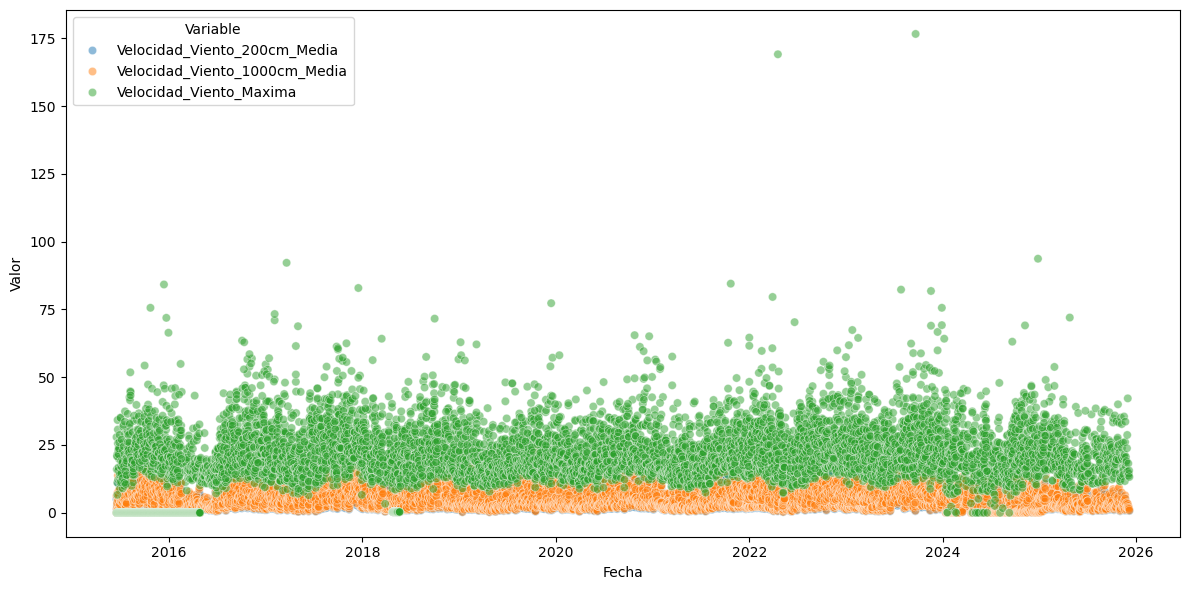

In [62]:
# Grupo 1

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo1])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo1,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

# Grupo 2

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo2])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo2,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

# Grupo 3

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo3])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo3,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

# Grupo 4

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo4])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo4,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

# Grupo 5

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo5])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo5,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

# Grupo 6

plt.figure(figsize = (12, 6))
sns.boxplot(data = df[grupo6])
plt.tight_layout()
plt.show()

df_long = df.melt(
    id_vars ='Fecha',
    value_vars = grupo6,
    var_name ='Variable',
    value_name ='Valor'
)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = df_long,
    x ='Fecha',
    y ='Valor',
    hue = 'Variable',
    alpha = 0.5
)
plt.tight_layout()
plt.show()

### Resumen estadístico

In [49]:
# Obtener las principales medidas de posición y de dispersión de cada variable.

display(df.drop(columns=['Fecha', 'Latitud', 'Longitud']).describe())

,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Suelo_10cm_Media,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Velocidad_Viento_1000cm_Media,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
count,9508.000000,9493.000000,9487.000000,9116.000000,9149.000000,9129.000000,8324.000000,9437.000000,9502.000000,9475.000000,8754.000000,9041.000000,8998.000000,8998.000000,9049.000000,9041.000000,9041.000000,9426.000000,9427.000000
mean,21.293295,27.986853,15.902951,23.690962,3.006695,3.016639,1.188011,19.438241,74.706588,73.168338,16.477594,3.565280,4.479905,5.599881,22.070803,1004.726982,15.510097,0.530281,-15.872573
std,5.623973,6.378189,5.751355,5.825771,11.224704,11.647958,4.363469,6.838117,17.394758,17.093648,5.583937,4.575034,3.036514,3.795643,10.144486,6.122959,7.863327,2.067324,10.680907
min,3.411111,9.500000,-28.100000,-6.800000,0.000000,0.000000,0.000000,0.005219,0.000000,3.000000,-7.962359,0.000000,0.000000,0.000000,0.000000,986.276100,0.021720,0.000000,-23.904030
25%,17.363370,23.600000,12.100000,19.157812,0.000000,0.000000,0.000000,14.445150,65.000000,62.000000,12.848688,0.000000,2.221701,2.777127,16.100000,1000.378000,9.587220,0.000000,-23.904030
50%,21.935415,28.500000,16.700000,23.941665,0.000000,0.000000,0.000000,19.222560,77.000000,75.000000,17.068095,1.083333,3.951736,4.939671,20.700000,1004.110000,15.168900,0.000000,-21.331020
75%,25.551730,32.700000,20.200000,27.848092,0.000000,0.000000,0.000000,24.225840,87.000000,86.000000,20.685068,6.766665,6.188195,7.735243,26.800000,1008.708000,22.137240,0.000000,-10.624000
max,42.958320,60.000000,43.300000,50.000000,169.000000,220.000000,58.200000,73.201940,100.000000,100.000000,34.391040,23.999980,18.634730,23.293410,176.600000,1033.712000,32.272730,18.924020,19.505020


### Visualizaciones: análisis univariado, bivariado y multivariado

### Preprocesamiento y limpieza avanzada de datos.

### Conclusiones parciales

In [ ]:
# Elaborar conclusiones parciales que sinteticen los principales hallazgos del análisis
# exploratorio y las decisiones de preprocesamiento adoptadas.

## Modelado, Evaluación e Interpretabilidad

### Selección de modelos

Seleccionar al menos dos algoritmos de machine learning adecuados para el problema
planteado y justificar su elección.

### Entrenamiento, validación y optimización de modelos

Realizar el entrenamiento de los modelos seleccionados, incorporando técnicas de
validación cruzada (cross-validation) y la optimización de hiperparámetros mediante algún
método de búsqueda (por ejemplo, Grid Search, Random Search u otros).

Describir el esquema de validación utilizado y los principales hiperparámetros optimizados.

### Evaluación y análisis de resultados

Evaluar y comparar el desempeño de los modelos utilizando métricas adecuadas para el
problema.

Visualizar y analizar el output de los modelos, incluyendo comparaciones entre valores
reales y predichos sobre el conjunto de test.

Detallar y representar gráficamente la “confianza” o incertidumbre asociada a las
predicciones, cuando corresponda.

### Interpretabilidad de los modelos

Realizar un análisis de interpretabilidad de los modelos entrenados, identificando las variables
más relevantes y discutiendo su impacto en las predicciones.

### Conclusiones

Elaborar conclusiones integradoras a partir de los resultados obtenidos, destacando
fortalezas, limitaciones y posibles mejoras
